<a href="https://colab.research.google.com/github/dominiksakic/NETworkingMay/blob/main/19_adv_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-05-24 02:00:46--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.178.129, 52.217.197.128, 16.15.193.231, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.178.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  60.4MB/s    in 0.2s    

2025-05-24 02:00:46 (60.4 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
fname = os.path.join("jena_climate_2009_2016.csv")

# Text file
with open(fname) as f:
  data = f.read()

# Transform dataN
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] # exclude the headers

# Store data in numpy, for working with it later
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) # Minus the Datetime!

for i, line in enumerate(lines):
  # remove Datetime from lines
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [4]:
from tensorflow import keras

# prepare the data
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

# Normalize data, only on the train_samples NO DATA LEAKAGE
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256


train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 169s 200ms/step - loss: 54.0373 - mae: 5.4520 - val_loss: 9.9034 - val_mae: 2.4506
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 199ms/step - loss: 15.3936 - mae: 3.0505 - val_loss: 9.1971 - val_mae: 2.3570
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 165s 201ms/step - loss: 14.5486 - mae: 2.9560 - val_loss: 9.0558 - val_mae: 2.3326
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 165s 201ms/step - loss: 13.9397 - mae: 2.8927 - val_loss: 8.9444 - val_mae: 2.3176
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 166s 203ms/step - loss: 13.5477 - mae: 2.8514 - val_loss: 8.8724 - val_mae: 2.3034
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 201s 202ms/step - loss: 13.1085 - mae: 2.8118 - val_loss: 9.0527 - val_mae: 2.3287
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 166s 202ms/step - loss: 12.8495 - mae: 2.7808 - val_loss: 8.7892 - val_mae: 2.2979
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 164s 200ms/step - loss: 12.5909 - mae: 2.7518 - val_loss: 8.7529 - val_mae: 2.2997
Epoch 9/50
819/8

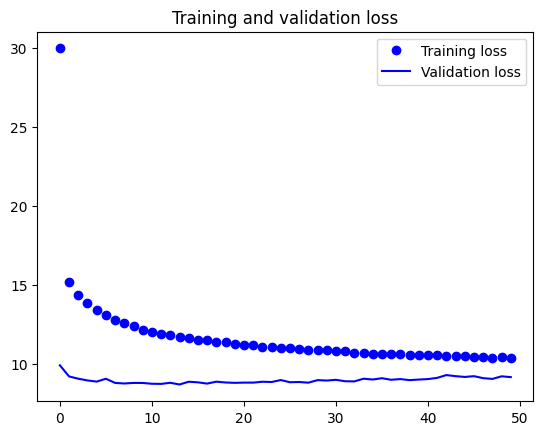

In [6]:
history = history.history

loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

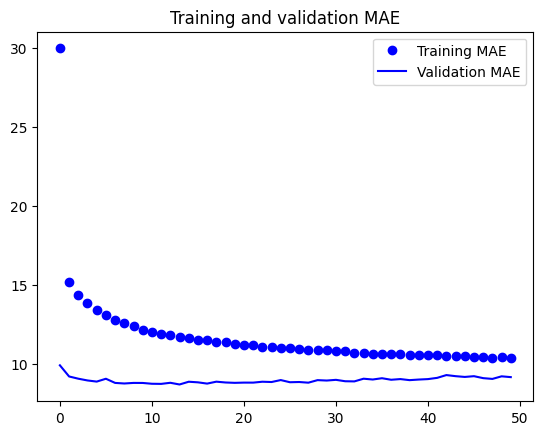

In [7]:
mae = history["mae"]
val_mae = history["val_mae"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()